# Tumors

In [57]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [58]:
import seaborn as sns
sns.set()

In [59]:
df = pd.read_excel("/Users/samwwong/Desktop/Michael Zhang/atrt_mb_features.xlsx")

In [60]:
df.head()

,id,molec,path,inst,t1_log-sigma-1-mm-3D_firstorder_10Percentile,t1_log-sigma-1-mm-3D_firstorder_90Percentile,t1_log-sigma-1-mm-3D_firstorder_Energy,t1_log-sigma-1-mm-3D_firstorder_Entropy,t1_log-sigma-1-mm-3D_firstorder_InterquartileRange,t1_log-sigma-1-mm-3D_firstorder_Kurtosis,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,CG_PF-MB_M_0001_,other,mb,CG,-25.219442,16.497916,8891508.15,2.832741,21.553029,4.665331,...,2.046358,0.001964,2285.615615,0.379670,0.639573,857.481874,0.001500,7.542019,0.202339,1846.198652
1,CG_PF-MB_U_0002_,other,mb,CG,-19.829551,17.167626,13099908.90,2.613348,14.634901,11.210612,...,7.071965,0.000995,2960.526102,0.400396,0.657135,1573.328026,0.000558,7.841823,0.165532,7393.889573
2,CG_PF-MB_U_0003_,other,mb,CG,-26.324259,23.843131,16202381.50,3.072182,25.340992,3.710662,...,2.189343,0.001461,3107.165961,0.375852,0.636253,1069.732546,0.000904,7.893590,0.218912,1332.374317
3,CG_PF-MB_U_0004_,shh,mb,CG,-10.286191,7.504317,2369243.46,1.763421,8.596255,6.002950,...,0.735240,0.000488,3587.985098,0.408143,0.664023,4133.253093,0.000387,8.606348,0.208807,2774.748606
4,CG_PF-MB_U_0005_,other,mb,CG,-12.364784,9.052869,3973511.62,1.988826,10.305779,8.252516,...,1.899261,0.000787,4415.729118,0.426888,0.679228,1934.967931,0.000548,7.895451,0.225139,2351.904374


In [61]:
reduced_features = pd.read_excel("/Users/samwwong/Desktop/Michael Zhang/LASSO_reduced_features.xlsx")

In [62]:
reduced_features_list = reduced_features.loc[reduced_features['ATRT/MB'].isnull() == False, ['ATRT/MB']].values.tolist()

In [63]:
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [64]:
reduced_features_list

['t1_original_shape_Elongation',
 't2_log-sigma-5-mm-3D_firstorder_90Percentile',
 't2_original_shape_Elongation',
 't2_original_shape_Flatness',
 't2_wavelet-LLL_glcm_Idmn',
 't2_wavelet-HLL_firstorder_Kurtosis']

In [65]:
target = df["path"]

In [66]:
target.value_counts()

mb      96
atrt    48
Name: path, dtype: int64

In [67]:
#Marking 0 as atrt and 1 as mb
#target = target.map(dict(atrt = 1, mb = 0))
target = target.map(dict(mb = 1, atrt = 0))

In [68]:
features_after_lasso = df[reduced_features_list]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, 
                                                    test_size = 0.25, random_state = 42)

In [70]:
y_train.value_counts()

1    71
0    37
Name: path, dtype: int64

In [71]:
y_test.value_counts()

1    25
0    11
Name: path, dtype: int64

# Resampling to Correct for Imbalance

In [72]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['path'] == 0]
X_1 = X[X['path'] == 1]

In [73]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [74]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

In [75]:
y_train.value_counts()

1    71
0    71
Name: path, dtype: int64

# Standardizing Features

In [76]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [77]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [78]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

In [79]:
def create_ci(bootstrapped_scores, name):
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    print("95% Confidence interval for the {} score: [{:0.3f} - {:0.3}]".format(name, 
    confidence_lower, confidence_upper))

In [80]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TN / (TN + FP)

# SVM

### Grid Search for Hyperparameters

In [81]:
svm_model = svm.SVC()
grid_param = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']
}

svm_grid = GridSearchCV(estimator=svm_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [82]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             scoring='accuracy')

In [83]:
print(svm_grid.best_params_)

{'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}


### Model Performance

In [84]:
svm_model = svm.SVC(C = 1, gamma = 0.1, kernel = 'sigmoid', probability = True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [85]:
y_train_pred = svm_model.predict(X_train)

In [86]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.8055555555555556
Specificity Score: 0.8181818181818182
Precision: 0.9090909090909091
Recall: 0.8
F1 Score: 0.8510638297872342


In [87]:
svm_probs = svm_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
auc = roc_auc_score(y_test, svm_probs)
print("AUC: " + str(auc))

AUC: 0.850909090909091


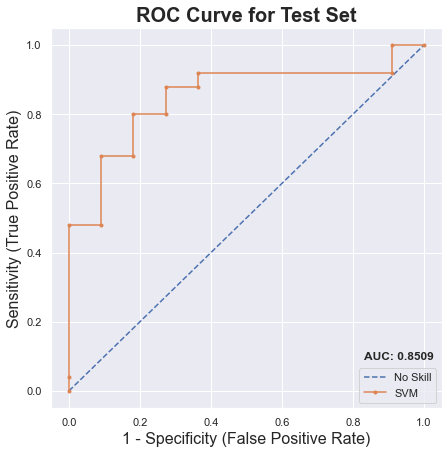

In [88]:
plt.figure(figsize=(7, 7))


ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVM')
plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

plt.legend(loc='lower right')
plt.title('ROC Curve for Test Set', fontsize=20, fontweight="semibold")
short_auc = round(auc,4)
plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=12, fontweight="semibold")
    
plt.show()

In [89]:
sns.reset_orig()

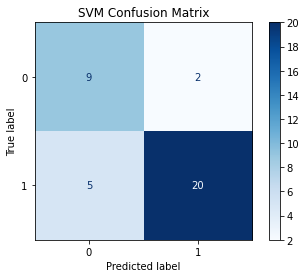

In [90]:
matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show(matrix)
plt.show()

In [91]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(svm_probs), len(svm_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], svm_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

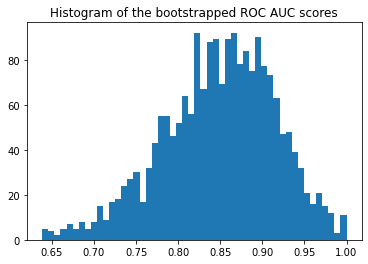

In [92]:
plt.hist(bootstrapped_auc_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [93]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.704 - 0.969]
95% Confidence interval for the Accuracy score: [0.667 - 0.917]
95% Confidence interval for the Specificity score: [0.545 - 1.0]
95% Confidence interval for the Precision score: [0.765 - 1.0]
95% Confidence interval for the Recall score: [0.636 - 0.955]
95% Confidence interval for the F1 score: [0.723 - 0.943]


# Logistic Regression

### Grid Search for Hyperparameters

In [94]:
lr_model = LogisticRegression()
grid_param = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [10, 1, 0.1, 0.01, 0.001]
}

lr_grid = GridSearchCV(estimator=lr_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [95]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 1, 0.1, 0.01, 0.001],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='accuracy')

In [96]:
print(lr_grid.best_params_)

{'C': 0.01, 'penalty': 'l2'}


### Model Performance

In [97]:
lr_model = LogisticRegression(penalty = 'l2', C = 0.01)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [98]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.8055555555555556
Specificity Score: 0.8181818181818182
Precision: 0.9090909090909091
Recall: 0.8
F1 Score: 0.8510638297872342


In [99]:
lr_probs = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
auc = roc_auc_score(y_test, lr_probs)
print("AUC: " + str(auc))

AUC: 0.8581818181818183


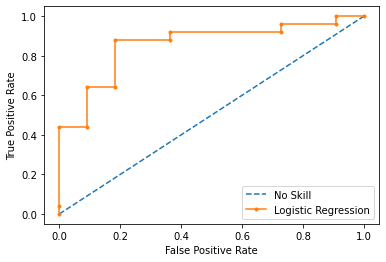

In [100]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

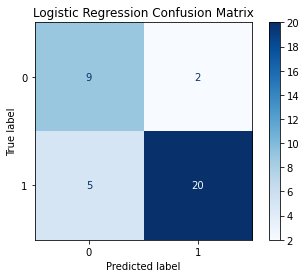

In [101]:
matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

In [102]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(lr_probs), len(lr_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], lr_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [103]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.712 - 0.969]
95% Confidence interval for the Accuracy score: [0.667 - 0.917]
95% Confidence interval for the Specificity score: [0.545 - 1.0]
95% Confidence interval for the Precision score: [0.765 - 1.0]
95% Confidence interval for the Recall score: [0.636 - 0.955]
95% Confidence interval for the F1 score: [0.723 - 0.943]


In [104]:
feature_labels_dict = {'t1_original_shape_Elongation': 'T1 Original Shape Elongation', 
                      't2_log-sigma-5-mm-3D_firstorder_90Percentile': 'T2 Log Sigma 5mm 3D 90th Percentile (1st Order)',
                          't2_original_shape_Elongation': 'T2 Original Shape Elongation',
                          't2_original_shape_Flatness': 'T2 Original Shape Flatness',
                      't2_wavelet-LLL_glcm_Idmn': 'T2 Wavelet LLL Glcm Idmn',
                      't2_wavelet-HLL_firstorder_Kurtosis': 'T2 Wavelet HLL Kurtosis (1st Order)',}

In [105]:
sns.set()

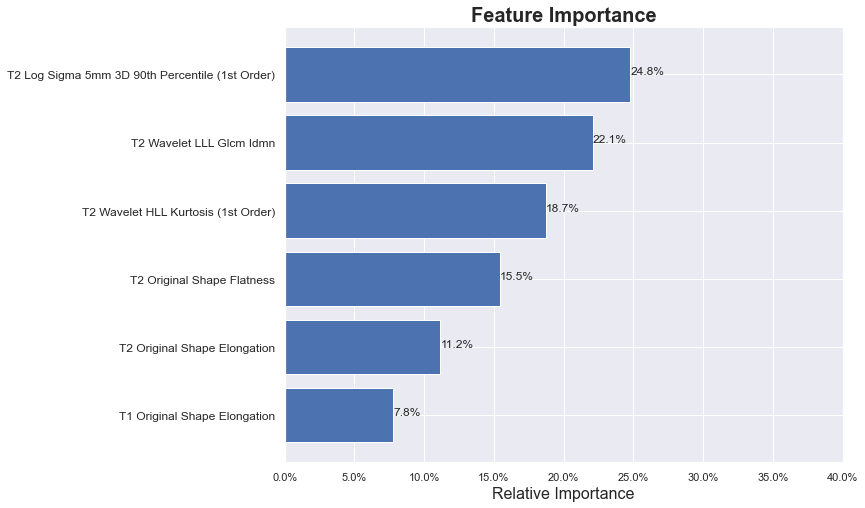

In [106]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.4)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, "{:.1%}".format(value), fontsize=12)
plt.yticks(range(len(indices)), [feature_labels_dict[feature_names[i]] for i in indices],fontsize=12)
plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

In [107]:
sns.reset_orig()

# KNN

### Grid Search for Hyperparameters

In [108]:
knn_model = KNeighborsClassifier()
grid_param = {'n_neighbors': [3, 5, 7, 9]
}

knn_grid = GridSearchCV(estimator=knn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [109]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='accuracy')

In [110]:
print(knn_grid.best_params_)

{'n_neighbors': 5}


### Model Performance

In [111]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [112]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.8333333333333334
Specificity Score: 0.9090909090909091
Precision: 0.9523809523809523
Recall: 0.8
F1 Score: 0.8695652173913043


In [113]:
knn_probs = knn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
auc = roc_auc_score(y_test, knn_probs)
print("AUC: " + str(auc))

AUC: 0.8418181818181818


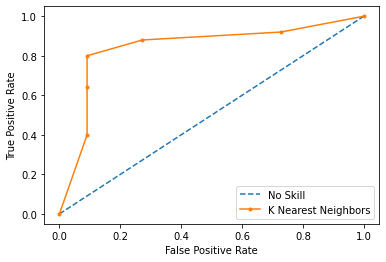

In [114]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='K Nearest Neighbors')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

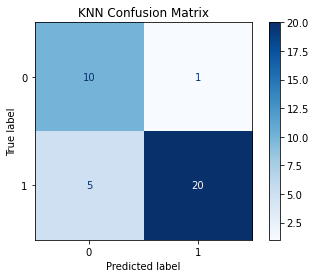

In [115]:
matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.show(matrix)
plt.show()

In [116]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(knn_probs), len(knn_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], knn_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [117]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.672 - 0.971]
95% Confidence interval for the Accuracy score: [0.722 - 0.944]
95% Confidence interval for the Specificity score: [0.700 - 1.0]
95% Confidence interval for the Precision score: [0.842 - 1.0]
95% Confidence interval for the Recall score: [0.636 - 0.957]
95% Confidence interval for the F1 score: [0.745 - 0.96]


# Random Forest

### Grid Search for Hyperparameters
 

In [118]:
rf_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_grid = GridSearchCV(estimator=rf_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [119]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [None, 50, 100, 200, 300]},
             scoring='accuracy')

In [120]:
print(rf_grid.best_params_)

{'max_depth': 3, 'n_estimators': 200}


### Model Performance

In [121]:
rf_model = RandomForestClassifier(max_depth = 3, n_estimators = 200, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [122]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.7777777777777778
Specificity Score: 0.6363636363636364
Precision: 0.84
Recall: 0.84
F1 Score: 0.8399999999999999


In [123]:
rf_probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
auc = roc_auc_score(y_test, rf_probs)
print("AUC: " + str(auc))

AUC: 0.8072727272727273


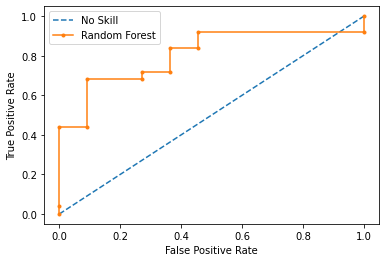

In [124]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

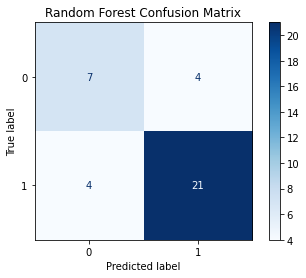

In [125]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

In [126]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(rf_probs), len(rf_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], rf_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [127]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.647 - 0.944]
95% Confidence interval for the Accuracy score: [0.639 - 0.917]
95% Confidence interval for the Specificity score: [0.333 - 0.909]
95% Confidence interval for the Precision score: [0.679 - 0.963]
95% Confidence interval for the Recall score: [0.692 - 0.962]
95% Confidence interval for the F1 score: [0.711 - 0.935]


In [159]:
sns.set()

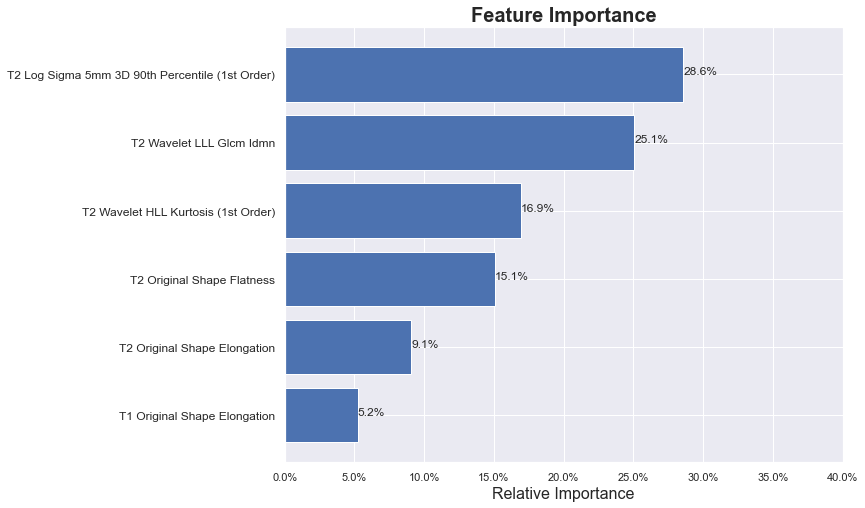

In [160]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.4)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, "{:.1%}".format(value), fontsize=12)
plt.yticks(range(len(indices)), [feature_labels_dict[feature_names[i]] for i in indices],fontsize=12)
plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

In [161]:
sns.reset_orig()

# XGBoost

### Grid Search for Hyperparameters

In [131]:
xgb_model = XGBClassifier(random_state = 42)
grid_param = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

xgb_grid = GridSearchCV(estimator=xgb_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [132]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [133]:
print(xgb_grid.best_params_)

{'learning_rate': 0.3, 'max_depth': 5}


### Model Performance

In [134]:
xgb_model = XGBClassifier(learning_rate = 0.3, max_depth = 5, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [135]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.6944444444444444
Specificity Score: 0.45454545454545453
Precision: 0.7692307692307693
Recall: 0.8
F1 Score: 0.7843137254901961


In [136]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
auc = roc_auc_score(y_test, xgb_probs)
print("AUC: " + str(auc))

AUC: 0.7418181818181818


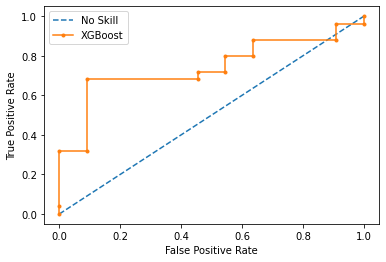

In [137]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

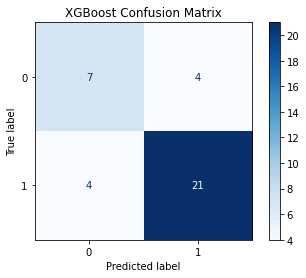

In [138]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

In [139]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(xgb_probs), len(xgb_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], xgb_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [140]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.571 - 0.896]
95% Confidence interval for the Accuracy score: [0.556 - 0.833]
95% Confidence interval for the Specificity score: [0.167 - 0.75]
95% Confidence interval for the Precision score: [0.600 - 0.923]
95% Confidence interval for the Recall score: [0.640 - 0.955]
95% Confidence interval for the F1 score: [0.638 - 0.898]


In [155]:
sns.set()

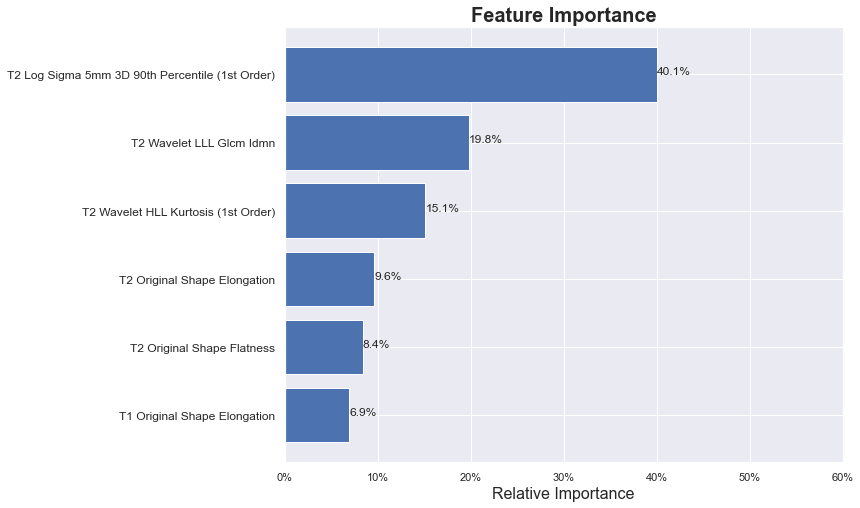

In [156]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.6)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, "{:.1%}".format(value), fontsize=12)
plt.yticks(range(len(indices)), [feature_labels_dict[feature_names[i]] for i in indices],fontsize=12)
plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

In [157]:
sns.reset_orig()

# Neural Net

### Grid Search for Hyperparameters

In [144]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_grid = GridSearchCV(estimator=nn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [145]:
nn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [146]:
print(nn_grid.best_params_)

{'hidden_layer_sizes': (100, 50, 100), 'learning_rate': 'constant'}


### Model Performance

In [147]:
nn_model = MLPClassifier(hidden_layer_sizes = (100, 50, 100), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [148]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.75
Specificity Score: 0.6363636363636364
Precision: 0.8333333333333334
Recall: 0.8
F1 Score: 0.816326530612245


In [149]:
nn_probs = nn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
auc = roc_auc_score(y_test, nn_probs)
print("AUC: " + str(auc))

AUC: 0.730909090909091


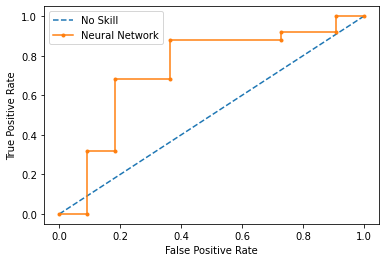

In [150]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

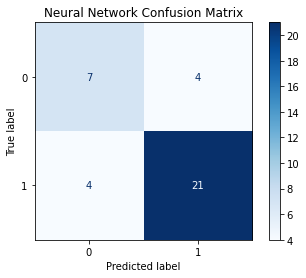

In [151]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

In [152]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(nn_probs), len(nn_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], nn_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [153]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.518 - 0.924]
95% Confidence interval for the Accuracy score: [0.583 - 0.889]
95% Confidence interval for the Specificity score: [0.333 - 0.923]
95% Confidence interval for the Precision score: [0.667 - 0.962]
95% Confidence interval for the Recall score: [0.636 - 0.947]
95% Confidence interval for the F1 score: [0.682 - 0.926]
